# Understand the HDDM object

HDDM model object is the results of HDDM modeling. Understand it's structure is essential for using it.

First and formost, HDDM is using python, which is an object-oriented language, which means that a lot of objects have predefined properties.

Second, HDDM used `pymc2.3.8`, thus HDDM model object inherit the properties of `pymc 2.3.8`. 

**Here, the purporse of this notebook is to dissect the HDDM model object and then integrate it with arviz.** More specifically, here I focused on how to get the pointwise log likelihood, likelihood function, prior predicitve check and posterior predicitive check.

In [1]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import glob
import kabuki 
import datetime
from datetime import date
from copy import deepcopy

import pymc as pm
import hddm
import kabuki
import arviz as az

from patsy import dmatrix, demo_data
print("The current HDDM version is: ", hddm.__version__)
print("The current ArviZ version is: ", az.__version__)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# import sparse # test whether package `sparse` is installed; doesn't matter if not installed.

from p_tqdm import p_map
from functools import partial

import feather

# set the color of plots
from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


The current HDDM version is:  0.8.0
The current ArviZ version is:  0.11.4


##  Related scripts

https://github.com/hddm-devs/kabuki/blob/master/kabuki/analyze.py#L287

## Understand `pymc` knode

In HDDM, PPC is based on `pymc` knode, which makes it very convenient.

In [2]:
data = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')
data.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


We cna easily check the design matrix of parameter `a` for the example mentioned in the HDDM official toturails.

## Fit an example model

Here we will use two modesl as examples: `model 2` (a full DDM model with `v` varying across conflict levels) and `model 7` (the model that has been selected).

In [3]:
# parameters for model fitting
samples = 25000  # Cavanagh used 30,000 and 10, 000 burn.
burn = 10000     
nppc = 1000     # 1000 samples for posterior predictive, super slow
thin = 3
chains = 4
test_mode = True

In [4]:
%%time

## total time: 5h 19s when test_mode is False

## Step 1: run models in parallel
file_path = "/home/jovyan/hddm/temp/"

if test_mode:
    # we define the models in a python file
    from Def_Models import run_m2, run_m7
    m_func = [run_m2, run_m7]
    m_keys  = ["ms2","ms7"]
    models  = {"ms2": [], "ms7": []}
    InfData = {"ms2": [], "ms7": []} 

else: 
    from Def_Models import run_m0, run_m1, run_m2, run_m3, run_m4, run_m5, run_m6, run_m7
    m_func = [run_m0, run_m1, run_m2, run_m3, 
                  run_m4, run_m5, run_m6, run_m7]
    m_keys = ["ms0", "ms1", "ms2",
              "ms3", "ms4", "ms5",
              "ms6", "ms7"]
    
    models = {"ms0": [], "ms1": [], "ms2": [], 
              "ms3": [], "ms4": [], "ms5": [], 
              "ms6": [], "ms7": []}

    InfData = {"ms0": [], "ms1": [], "ms2": [],
               "ms3": [], "ms4": [], "ms5": [], 
               "ms6": [], "ms7": []} 

for ii in range(len(m_func)):
    
    key = m_keys[ii]
    
    ####------------------ fitting the model or loading model object ------------------
    file_full_path = file_path + "/" + m_keys[ii] + "_tmp1_chain_*[!db]" 
    file_names = glob.glob(file_full_path, recursive=False)
    print(file_names)
    
    if file_names:
        for jj in file_names:
            print('current loading: ', jj, '\n')
            models[m_keys[ii]].append(hddm.load(jj))
    else:
        print('current estimating:', m_keys[ii])
        models[m_keys[ii]] = p_map(partial(m_func[ii], df=data, samples=samples, burn=burn),
                                   range(chains))
    
    ####------------------ Getting posterior samples  --------------------------------
    trace_tmp = []
    df_traces_tmp = []
    for jj in range(len(models[m_keys[ii]])):
        trace_tmp = models[m_keys[ii]][jj].get_traces()
        trace_tmp['chain'] = jj
        trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
        df_traces_tmp.append(trace_tmp)
    df_traces_tmp = pd.concat(df_traces_tmp)
   
    ####------------------ Getting posterior predictives -----------------------------
    df_ppc_tmp = []
    ftr_path = file_path + "df_" + key + "_tmp1_ppc_chain_*ftr" 
    ftr_names = glob.glob(ftr_path, recursive=False)

    # if there are ftr files
    if ftr_names:
        print("Got feather file names, loading the PPC")
        for ftrname in ftr_names:
#             for f_id in range(len(ftr_names)):
            print("loading \n", ftrname)
            df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
            df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
            df_ppc_tmp.append(df_tmp)     
    else:
        print("No feather files either, run PPC now ...")
        print("Generating PPC ", key, "for", m_keys[ii])
        start_time = time.time()  # the start time of the processing
        df_ppc_tmp = p_map(partial(post_pred_gen, samples = nppc), models[m_keys[ii]])
        print("Running PPC costs %f seconds" % (time.time() - start_time))
        print("Save PPC to feather files")
        for chain in range(len(df_ppc[key])):
            ftrname = file_path + "df_" + key + "_ppc_chain_" + str(chain) + ".ftr"
#             print(ftrname)
            df_ppc_tmp[chain].reset_index().to_feather(ftrname)
     
    ####------------------ Getting pointwise log likelihood ------------------------
    df_pll_tmp = []
    ftr_path = file_path + "df_" + key + "_tmp1_pll_chain_*ftr" 
    ftr_names = glob.glob(ftr_path, recursive=False)

    if ftr_names:
        print("Got feather file names, loading the loglik files")
        for ftrname in ftr_names:
            print("loading \n", ftrname)
            df_tmp = pd.read_feather(ftrname, columns=None, use_threads=True)
            df_tmp = df_tmp.set_index(["node", "draw", 'trial_idx'])
            df_pll_tmp.append(df_tmp)
    else:
        print("No feather files either, run loglik now ...")

        ms = models[m_keys[ii]]
        print("Generating loglik ", key, "for", m_keys[ii])
        start_time = time.time()  # the start time of the processing
        # df_pll[m_keys[ii]] = p_map(partial(pointwise_like_gen, samples = 500), ms)
        df_pll_tmp = p_map(partial(pointwise_like_gen), ms)

        print("Generating loglik costs %f seconds" % (time.time() - start_time))

        print("Save loglik to feather files")
        for chain in range(len(df_pll[key])):
            ftrname = file_path + "df_" + key + "_tmp1_pll_chain_" + str(chain) + ".ftr"
            print(ftrname)
            df_pll_tmp[chain].reset_index().to_feather(ftrname)
    
    ####------------------ Getting pointwise log likelihood ------------------------
    #     for ii in range(len(models)):
    obs_data = models[key][0].data.copy()
    obs_data.index.names = ['trial_idx']
    
    if 'conf' in obs_data.columns:
        obs_data.drop(['subj_idx','stim', 'theta','dbs','conf'], axis=1, inplace=True)
    
    xdata_observed = xr.Dataset.from_dataframe(obs_data)

    df_traces_tmp = df_traces_tmp.set_index(["chain", "draw"])
    xdata_posterior = xr.Dataset.from_dataframe(df_traces_tmp)

    df_ppc_tmp = pd.concat(df_ppc_tmp, names=['chain'], 
                            keys = list(range(len(df_ppc_tmp))))
    df_ppc_tmp = df_ppc_tmp.reset_index(level=1, drop=True)
    xdata_post_pred = xr.Dataset.from_dataframe(df_ppc_tmp)

    df_pll_tmp = pd.concat(df_pll_tmp, names=['chain'], 
                            keys = list(range(len(df_pll_tmp))))
    df_pll_tmp = df_pll_tmp.reset_index(level=1, drop=True)
    xdata_loglik = xr.Dataset.from_dataframe(df_pll_tmp)

    InfData[m_keys[ii]] = az.InferenceData(posterior=xdata_posterior, 
                                             observed_data=xdata_observed,
                                             posterior_predictive=xdata_post_pred,
                                             log_likelihood = xdata_loglik)
    

['/home/jovyan/hddm/temp/ms2_tmp1_chain_2', '/home/jovyan/hddm/temp/ms2_tmp1_chain_1', '/home/jovyan/hddm/temp/ms2_tmp1_chain_3', '/home/jovyan/hddm/temp/ms2_tmp1_chain_0']
current loading:  /home/jovyan/hddm/temp/ms2_tmp1_chain_2 

current loading:  /home/jovyan/hddm/temp/ms2_tmp1_chain_1 

current loading:  /home/jovyan/hddm/temp/ms2_tmp1_chain_3 

current loading:  /home/jovyan/hddm/temp/ms2_tmp1_chain_0 

Got feather file names, loading the PPC
loading 
 /home/jovyan/hddm/temp/df_ms2_tmp1_ppc_chain_0.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_tmp1_ppc_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_tmp1_ppc_chain_2.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_tmp1_ppc_chain_1.ftr
Got feather file names, loading the loglik files
loading 
 /home/jovyan/hddm/temp/df_ms2_tmp1_pll_chain_2.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_tmp1_pll_chain_3.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_tmp1_pll_chain_1.ftr
loading 
 /home/jovyan/hddm/temp/df_ms2_tmp1_pll_chain_0.ftr
['/home/jo

## Understand the model object's structure


In [5]:
ms2_tmp = models['ms2'][0]
ms2_tmp
ms7_tmp = models['ms7'][0]
ms7_tmp

Test prior predicitive code

In [15]:
from prior_pred_gen import _PP_generate
import pymc.progressbar as pbar

In [16]:
tmp7 = ((name, ms7_tmp.data.loc[obs['node'].value.index]) for name, obs in ms7_tmp.iter_observeds())

In [21]:
results = {}
progress_bar = True
append_data=False

# Progress bar
if progress_bar:
    n_iter = len(ms7_tmp.get_observeds())
    bar = pbar.progress_bar(n_iter)
    bar_iter = 0
else:
    print("Sampling...")
    
for name, data in tmp7:
    node = ms7_tmp.get_data_nodes(data.index)

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    if node is None or not hasattr(node, 'random'):
        continue # Skip

    ##############################
    # Sample and generate stats
    datasets = _PP_generate(node, pp_type='prior', samples=20, data=data, append_data=append_data)
    results[name] = pd.concat(datasets, names=['draw'], keys=list(range(len(datasets)))) 

 [-----------------92%---------------   ] 13 of 14 complete in 184.4 sec

In [25]:
name

'wfpt.13'

In [26]:
data

,subj_idx,stim,rt,response,theta,dbs,conf
trial_idx,,,,,,,
3714,13,WW,1.500,1.0,-0.482485,1,HC
3715,13,WL,0.929,1.0,1.503320,1,LC
3716,13,WL,1.880,1.0,-0.375840,1,LC
3717,13,LL,-1.180,0.0,-0.851146,1,HC
3718,13,WL,1.810,1.0,0.409289,1,LC
...,...,...,...,...,...,...,...
3983,13,LL,-1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC


In [28]:
bottom_node = node
pp_type="prior"
samples=20
data=data
append_data=False

In [30]:
datasets = []

In [29]:
for i, parent in enumerate(bottom_node.extended_parents):
    if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
        continue
    else:
        mc_len = len(parent.trace())
        break

In [31]:
mc_len

5000

In [32]:
if samples is None:
    samples = mc_len
    print("Number of samples is equal to length of MCMC trace.")
samples

20

In [33]:
pos = np.random.randint(0, mc_len)
pos

2908

In [35]:
pp_type == 'posterior'

False

In [34]:
if pp_type == 'posterior':
    _parents_to_posterior_sample(bottom_node, pos = pos)

In [36]:
bottom_node.random()

,rt
trial_idx,
3714,-2.875502
3715,3.400092
3716,2.990883
3717,1.249410
3718,-0.865963
...,...
3983,-0.967095
3984,2.617906
3985,1.496496


In [38]:
for i, parent in enumerate(bottom_node.extended_parents):
    print(parent, parent.value)

a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_subj.13 -0.029444527837630904
a_Intercept_subj.13 2.172716979420404
sz 0.08348860675966266
t_subj.13 0.6475415744217544
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_subj.13 0.042966544099406256
a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]_subj.13 -0.07731360199054362
v_C(conf, Treatment('LC'))[T.HC]_subj.13 -0.419641173756648
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.13 -0.04420205653105852
sv 0.16429887477008026
v_Intercept_subj.13 0.3324666368764414
st 0.4837753776137483
z_subj_trans.13 0.1338698136675232


In [42]:
parent.parents

{'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'z_trans' at 0x7fee636b1c50>,
 'tau': <pymc.PyMCObjects.Deterministic 'z_tau' at 0x7fee636b1a10>}

In [41]:
parent.parents.value

{'mu': array(0.13306402), 'tau': 3469.5539709894306}

In [43]:
parent.parents['mu'].parents

{'mu': 0.0, 'tau': 4.0}

In [46]:
parent.parents['tau'].parents['x'].parents

{'tau': 399.99999999999994}

In [22]:
results

{'wfpt.3':                       rt response
 draw trial_idx                   
 0    889       -1.770024        0
      890        3.340295        1
      891        2.765920        1
      892        0.813498        1
      893        3.154499        1
 ...                  ...      ...
 19   1139      -0.957364        0
      1140       1.882290        1
      1141      -1.251421        0
      1142      -1.508702        0
      1143      -1.379750        0
 
 [5100 rows x 2 columns],
 'wfpt.4':                       rt response
 draw trial_idx                   
 0    1144       1.304350        1
      1145       2.219915        1
      1146       0.791294        1
      1147       0.455218        1
      1148       1.333131        1
 ...                  ...      ...
 19   1422       0.898821        1
      1423      -1.757930        0
      1424       1.365466        1
      1425       0.981417        1
      1426       1.208876        1
 
 [5660 rows x 2 columns],
 'wfpt.5':    

In [23]:
prior_pred = pd.concat(results, names=['node'])

In [24]:
prior_pred

rt response
node    draw trial_idx                   
wfpt.3  0    889       -1.770024        0
             890        3.340295        1
             891        2.765920        1
             892        0.813498        1
             893        3.154499        1
...                          ...      ...
wfpt.13 19   3983      -1.859047        0
             3984       1.495433        1
             3985       1.630233        1
             3986      -1.601041        0
             3987       1.362941        1

[61980 rows x 2 columns]

### Model's input
Firstly, the input data were in the model object

In [7]:
ms2_tmp.data

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.210,1.0,0.656275,1,HC
1,0,WL,1.630,1.0,-0.327889,1,LC
2,0,WW,1.030,1.0,-0.480285,1,HC
3,0,WL,2.770,1.0,1.927427,1,LC
4,0,WW,-1.140,0.0,-0.213236,1,HC
...,...,...,...,...,...,...,...
3983,13,LL,-1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,-2.350,0.0,-0.546536,0,HC


`.value` will return all the values of the nodes contained in the model object.  some are stachastic, some are determinsitic

In [8]:
ms2_tmp.values

OrderedDict([('a', 1.6735424484603376),
             ('a_std', 0.4177886779820643),
             ('a_rate', 9.587897874684062),
             ('a_shape', 16.045754084786434),
             ('a_subj.0', 2.0066927360358693),
             ('a_subj.1', 1.9016928600128526),
             ('a_subj.2', 1.4236061607098542),
             ('a_subj.3', 2.0421031112029135),
             ('a_subj.4', 1.2597158677066014),
             ('a_subj.5', 1.5290149232457355),
             ('a_subj.6', 1.4063666113244064),
             ('a_subj.7', 1.6376089139277168),
             ('a_subj.8', 2.035257521022756),
             ('a_subj.9', 1.998640511838996),
             ('a_subj.10', 1.8954247918662708),
             ('a_subj.11', 2.574029332287951),
             ('a_subj.12', 1.7068077994474145),
             ('a_subj.13', 2.1855602776949032),
             ('v(HC)', 0.09568589869226263),
             ('v(LC)', 0.7960218977101599),
             ('v_std', 0.32196423449751876),
             ('v_tau', 9.64683251

In [9]:
ms7_tmp.values

OrderedDict([('t', 0.6066905866110108),
             ('t_std', 0.12334686715058127),
             ('t_rate', 39.87594695380462),
             ('t_shape', 24.192361649073277),
             ('t_subj.0', 0.7051455880235472),
             ('t_subj.1', 0.5469445183450504),
             ('t_subj.2', 0.6012945462883991),
             ('t_subj.3', 0.7098531107357561),
             ('t_subj.4', 0.4722768572062813),
             ('t_subj.5', 0.44497853638913704),
             ('t_subj.6', 0.5336189781417098),
             ('t_subj.7', 0.7283014490540005),
             ('t_subj.8', 0.680441133680681),
             ('t_subj.9', 0.5245480055678612),
             ('t_subj.10', 0.8279894161036843),
             ('t_subj.11', 0.8234580175088473),
             ('t_subj.12', 0.5650271342660316),
             ('t_subj.13', 0.6475415744217544),
             ('sv', 0.16429887477008026),
             ('sz', 0.08348860675966266),
             ('st', 0.4837753776137483),
             ('z_trans', 0.13306402095

### Nodes in the model.

The HDDM model object is an `pymc` model object *per se*, so it have almost all the properties of `pymc` objects, but more.

We can check the nodes in the model object by using `.nodes_db`.

We can see from the column names that there are `stochastic` nodes, `observed` nodes, and `hidden` nodes.

For `stochastic` nodes, we can also see their means, stds etc.

For `observed` nodes, we can find which variables are used as grouping factor. 

In [10]:
ms2_tmp.nodes_db

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,stim,...,dbs,conf,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,a,True,False,False,a,(),[],False,NaN,NaN,...,NaN,NaN,1.8367,0.108995,1.6329,1.76458,1.83338,1.90323,2.0665,0.00157731
a_std,a_std,True,False,False,a_std,(),[],False,NaN,NaN,...,NaN,NaN,0.382772,0.0914767,0.249137,0.319499,0.367574,0.428863,0.607078,0.00145429
a_rate,a_rate,False,False,False,a_rate,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_shape,a_shape,False,False,False,a_shape,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a_subj.0,a_subj,True,False,True,a_subj.0,(),[subj_idx],False,0,NaN,...,NaN,NaN,2.04668,0.0698414,1.91653,1.99923,2.04351,2.09305,2.18668,0.00107978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wfpt(LC).9,wfpt,False,True,False,wfpt(LC).9,"(LC,)","[conf, subj_idx]",False,9,NaN,...,NaN,LC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(LC).10,wfpt,False,True,False,wfpt(LC).10,"(LC,)","[conf, subj_idx]",False,10,NaN,...,NaN,LC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(LC).11,wfpt,False,True,False,wfpt(LC).11,"(LC,)","[conf, subj_idx]",False,11,NaN,...,NaN,LC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(LC).12,wfpt,False,True,False,wfpt(LC).12,"(LC,)","[conf, subj_idx]",False,12,NaN,...,NaN,LC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
ms7_tmp.nodes_db

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,stim,...,dbs,conf,mean,std,2.5q,25q,50q,75q,97.5q,mc err
t,t,True,False,False,t,(),[],False,NaN,NaN,...,NaN,NaN,0.618501,0.0356115,0.552753,0.594457,0.617133,0.64089,0.692873,0.000826575
t_std,t_std,True,False,False,t_std,(),[],False,NaN,NaN,...,NaN,NaN,0.112117,0.0269283,0.0718893,0.0933541,0.107801,0.126351,0.175673,0.000428007
t_rate,t_rate,False,False,False,t_rate,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
t_shape,t_shape,False,False,False,t_shape,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
t_subj.0,t_subj,True,False,True,t_subj.0,(),[subj_idx],False,0,NaN,...,NaN,NaN,0.703908,0.0374311,0.629021,0.678148,0.704736,0.730251,0.775066,0.000967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wfpt.9,wfpt,False,True,False,wfpt.9,(),[subj_idx],False,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.10,wfpt,False,True,False,wfpt.10,(),[subj_idx],False,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.11,wfpt,False,True,False,wfpt.11,(),[subj_idx],False,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.12,wfpt,False,True,False,wfpt.12,(),[subj_idx],False,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Observeds

The observed nodes are the nodes for input data (observed = True).

Depends on the model specification, the number of observeds are different. In `m2`, we used `conf` as a grouping factor (the `depends_on` argument), we can see that the `observed` is a combination of subject's id and two levels of `conf`. Whereas in `m7`, a regression model without depends_on argument, the observeds are equal to the number of participants.

In [12]:
ms2_tmp.get_observeds()

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,stim,...,dbs,conf,mean,std,2.5q,25q,50q,75q,97.5q,mc err
wfpt(HC).0,wfpt,False,True,False,wfpt(HC).0,"(HC,)","[conf, subj_idx]",False,0,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(HC).1,wfpt,False,True,False,wfpt(HC).1,"(HC,)","[conf, subj_idx]",False,1,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(HC).2,wfpt,False,True,False,wfpt(HC).2,"(HC,)","[conf, subj_idx]",False,2,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(HC).3,wfpt,False,True,False,wfpt(HC).3,"(HC,)","[conf, subj_idx]",False,3,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(HC).4,wfpt,False,True,False,wfpt(HC).4,"(HC,)","[conf, subj_idx]",False,4,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(HC).5,wfpt,False,True,False,wfpt(HC).5,"(HC,)","[conf, subj_idx]",False,5,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(HC).6,wfpt,False,True,False,wfpt(HC).6,"(HC,)","[conf, subj_idx]",False,6,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(HC).7,wfpt,False,True,False,wfpt(HC).7,"(HC,)","[conf, subj_idx]",False,7,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(HC).8,wfpt,False,True,False,wfpt(HC).8,"(HC,)","[conf, subj_idx]",False,8,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt(HC).9,wfpt,False,True,False,wfpt(HC).9,"(HC,)","[conf, subj_idx]",False,9,NaN,...,NaN,HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
ms7_tmp.get_observeds()

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,stim,...,dbs,conf,mean,std,2.5q,25q,50q,75q,97.5q,mc err
wfpt.0,wfpt,False,True,False,wfpt.0,(),[subj_idx],False,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.1,wfpt,False,True,False,wfpt.1,(),[subj_idx],False,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.2,wfpt,False,True,False,wfpt.2,(),[subj_idx],False,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.3,wfpt,False,True,False,wfpt.3,(),[subj_idx],False,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.4,wfpt,False,True,False,wfpt.4,(),[subj_idx],False,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.5,wfpt,False,True,False,wfpt.5,(),[subj_idx],False,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.6,wfpt,False,True,False,wfpt.6,(),[subj_idx],False,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.7,wfpt,False,True,False,wfpt.7,(),[subj_idx],False,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.8,wfpt,False,True,False,wfpt.8,(),[subj_idx],False,8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wfpt.9,wfpt,False,True,False,wfpt.9,(),[subj_idx],False,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can iterate the `observed` to check whether they are consistent with our input data.

In [14]:
iter_data_tmp2 = ((name2, ms2_tmp.data.loc[obs2['node'].value.index]) for name2, obs2 in ms2_tmp.iter_observeds())
iter_data_tmp2
iter_data_tmp7 = ((name7, ms7_tmp.data.loc[obs7['node'].value.index]) for name7, obs7 in ms7_tmp.iter_observeds())
iter_data_tmp7

<generator object <genexpr> at 0x7f2804d79e50>

In [15]:
for name2, data2 in iter_data_tmp2:
#     print(name)
    node2 = ms2_tmp.get_data_nodes(data2.index) # get the node corresponding to data.index.
print(name2)
node2

wfpt(LC).13


<pymc.distributions.new_dist_class.<locals>.new_class 'wfpt(LC).13' at 0x7f28225c9b90>

In [16]:
for name7, data7 in iter_data_tmp7:
#     print(name)
    node7 = ms7_tmp.get_data_nodes(data7.index) # get the node corresponding to data.index.
print(name7)
node7

wfpt.13


<pymc.distributions.new_dist_class.<locals>.new_class 'wfpt.13' at 0x7f281bfb4c50>

`node` has several properties: `value`, `parents`, `extended_parent`, `children`, etc.

The `value` of each observed node is its input data. In HDDM these data are flipped RTs, i.e., some are positive number, some are negative.

In [17]:
node2.value

,rt
3715,0.929
3716,1.880
3718,1.810
3719,-1.920
3724,2.300
...,...
3979,1.660
3980,1.890
3981,1.590
3984,0.711


In [18]:
node7.value

,rt
3714,1.500
3715,0.929
3716,1.880
3717,-1.180
3718,1.810
...,...
3983,-1.450
3984,0.711
3985,0.784
3986,-2.350


From the `parents` of each node, we can check the hyper-parameter, which is generated from `prior` distributions. Let's look into the details of two example nodes.

`node2`, which is from `ms2`, are from `HDDM()` function.

In [19]:
node2.parents

{'p_outlier': 0.05,
 'v': <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(LC).13' at 0x7f282274a450>,
 'sv': <pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7f2822945c50>,
 'a': <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.13' at 0x7f28227d9650>,
 'z': <pymc.CommonDeterministics.InvLogit 'z_subj.13' at 0x7f28226edb50>,
 'sz': <pymc.distributions.new_dist_class.<locals>.new_class 'sz' at 0x7f28227d9990>,
 't': <pymc.distributions.new_dist_class.<locals>.new_class 't_subj.13' at 0x7f2822777f90>,
 'st': <pymc.distributions.new_dist_class.<locals>.new_class 'st' at 0x7f28229f9950>}

As we can see from the output, there are eight hyper-parameters, seven of them are parameters of a full-DDM, and all these seven parameters are themselves `pymc` distribution objects.

as `node2.parents` is a python dictionary, we can extract each element by their `key`.

In [41]:
node2.parents['p_outlier']

0.05

We can focus on one parameter, and check if its parents are really from prior distributions. First, we need to recall how parameter `a` is generated in the hieriarchical model. 

$$ a_{j} \sim G(\mu_{a}, \sigma_{a}^{2})$$

the $j$ here means each group, in model 2, it is the subject.

So here we can predict that this paramter has two hyper-parameters (parents) that are the parameters of Gamma distribution. We can check this by `node2.parents['a'].parents`:

In [32]:
node2.parents['a']

<pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.13' at 0x7f28227d9650>

In [40]:
node2.parents['a'].value

array(2.18556028)

In [20]:
node2.parents['a'].parents  # a is a deterministic?

{'alpha': <pymc.PyMCObjects.Deterministic 'a_shape' at 0x7f2822a96c90>,
 'beta': <pymc.PyMCObjects.Deterministic 'a_rate' at 0x7f2822af7210>}

In [39]:
node2.parents['a'].parents.value

{'alpha': 16.045754084786434, 'beta': 9.587897874684062}

Here we can see that `a` does have two parents, one of them are `a_shape` object, the other is `a_rate` object. both are `Determinsitic` object of pymc 2.3.8. Which mean that their value a determined by some other values.

We can further check their parents (i.e., `a`'s parents' parents) and see how their parents defines their values.

In [23]:
node2.parents['a'].parents['alpha'].parents

{'x': <pymc.distributions.new_dist_class.<locals>.new_class 'a' at 0x7f2822af7350>,
 'y': <pymc.distributions.new_dist_class.<locals>.new_class 'a_std' at 0x7f2822adef90>}

In [31]:
node2.parents['a'].parents['beta'].parents

{'x': <pymc.distributions.new_dist_class.<locals>.new_class 'a' at 0x7f2822af7350>,
 'y': <pymc.distributions.new_dist_class.<locals>.new_class 'a_std' at 0x7f2822adef90>}

In [37]:
node2.parents['a'].parents['alpha'].parents.value

{'x': array(1.67354245), 'y': array(0.41778868)}

From the above, we can see that both `alpha` and `beta` are determined by the same parents: `x`, at 0x7f2822af7350, and `y`, at 0x7f2822adef90. And `x` is a `a` object, `y` is a `a_std` object.

To understand this part, we need to understand how this `a`'s parents, i.e., two parameters of a Gamma distribution, are transferred. Gamma distribution has two parameters: shape and rate, however, in HDDM, the input parameter were mu and sigma, as we can see in Wiecki et al (2013). Thus, the mu and sigma need to be transformed to shape and rate. Here is how the transform is done: $shape = \mu^2/\sigma^2$, $rate = \mu/\sigma^2$. 

So the `x` here is the $\mu$, and `y` here is the $\sigma$. These two parameter were transformed to `alpha` (`a_shape`) and `beta` (`a_rate`).

We can check whether this transform is correct:

In [38]:
print("a_shape: ", (1.67354245**2)/(0.41778868**2))
print("a_rate: ", 1.67354245/(0.41778868**2))

a_shape:  16.045753959307444
a_rate:  9.587897790885103


As we can see, using `x` and `y` as input, we can get the value of `a_rate` and `a_shape`, which is almost equal to the values of `alpha` and `beta` above.

We can further check the parents of `x` ($\mu_a$) and `y` ($\sigma_a$), because their value was from higher-order parameters:

$$\mu_{a} \sim G(1.5, 0.75)$$
$$\sigma_{a} \sim HN(0.1)$$

So, we further look at their parents.

In [24]:
node2.parents['a'].parents['alpha'].parents['x'].parents

{'alpha': 4.0, 'beta': 2.6666666666666665}

In [25]:
node2.parents['a'].parents['alpha'].parents['y'].parents

{'tau': 0.25}

From the above, we can see that `x`' and `y`'s parents are no longer pymc objects but numbers. But their are different from what we have seen from Wiecki (2013)'s paper. 

Here again, the transformation of parameter are invovled: while in the paper, $\mu$ and $\sigma$ are used, the gamma and half-normal distirubtion need different forms of parameter as input. Again, for gamma distriubtion, $shape = \mu^2/\sigma^2$, $rate = \mu/\sigma^2$, where the $\mu = 1.5$, and $\sigma = 0.75$. 

For half-normal distriubtion, it has only one parameter $\tau$, which is transformed from a input value: $\tau = std^{-2}$  where the std should be `0.1`. However, in the HDDM code, it seems there are some typo and the  $std$ here was defined as `2` (see [here](https://github.com/hddm-devs/hddm/blob/670a831e2b3cdb7275063584b1e45b7b435ad738/hddm/models/hddm_info.py#L124)).

In [34]:
print("g_shape: ", (1.5**2)/(0.75**2))
print("g_rate: ", 1.5/(0.75**2))
print("tau of std: ", 2**-2)

g_shape:  4.0
g_rate:  2.6666666666666665
tau of std:  0.25


From the above, I confirmed that the node2's parents are from prior. Below, I will further confirm that node7's parents are also from prior.

In [17]:
node7.parents

{'p_outlier': 0.05,
 'v': <pymc.PyMCObjects.Deterministic 'v_reg.13' at 0x7f15d6df7f10>,
 'sv': <pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7f15dcecf5d0>,
 'a': <pymc.PyMCObjects.Deterministic 'a_reg.13' at 0x7f15d71d5d50>,
 'z': <pymc.CommonDeterministics.InvLogit 'z_subj.13' at 0x7f15dc223510>,
 'sz': <pymc.distributions.new_dist_class.<locals>.new_class 'sz' at 0x7f15dc800610>,
 't': <pymc.distributions.new_dist_class.<locals>.new_class 't_subj.13' at 0x7f15dc764910>,
 'st': <pymc.distributions.new_dist_class.<locals>.new_class 'st' at 0x7f15dc7e1390>,
 'reg_outcomes': frozenset({'a', 'v'})}

In [66]:
node2.parents

{'p_outlier': 0.05,
 'v': <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(LC).13' at 0x7f282274a450>,
 'sv': <pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7f2822945c50>,
 'a': <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.13' at 0x7f28227d9650>,
 'z': <pymc.CommonDeterministics.InvLogit 'z_subj.13' at 0x7f28226edb50>,
 'sz': <pymc.distributions.new_dist_class.<locals>.new_class 'sz' at 0x7f28227d9990>,
 't': <pymc.distributions.new_dist_class.<locals>.new_class 't_subj.13' at 0x7f2822777f90>,
 'st': <pymc.distributions.new_dist_class.<locals>.new_class 'st' at 0x7f28229f9950>}

`.parents` is a python dictionary, thus, for each element in the parents, we can further check their values.

We can compare the parameter `a`: in `node7` (from m7),  it's a `determinstic` object `a_reg.13`, while in `node2`, it's a `new_dist` distriubtion `a_suj.13`, which, as we have seen above, is a `gamma_gamma_half-normal` distribution. 

In node7, `a_reg` is defined such that `a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))`. Let's check the inside of the`a` pymc object. 

Our first observation is that it is a list of values instead of just one value. So here it is a linear conbination of the linear function we defined above.

In [43]:
node7.parents['a'].value

3714    2.194044
3715    2.056490
3716    2.201775
3717    2.210339
3718    2.141073
          ...   
3983    2.119560
3984    2.183831
3985    2.193157
3986    2.149234
3987    2.205045
Name: 0, Length: 274, dtype: float64

Then, we check the hyper-parameters, it has one parent, `args`, which contains several elements: 
* `a_Intercept_subj.13`, 
* `a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_subj.13`, 
* `a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_subj.13`, 
* `a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.13`, 
* `a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]_subj.13`,

These are exactly the predictors in the linear regression formula of `a` we have created by `patsy`.

In [44]:
node7.parents['a'].parents

{'args': [<pymc.distributions.new_dist_class.<locals>.new_class 'a_Intercept_subj.13' at 0x7f2820fd2a90>,
  <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_subj.13' at 0x7f2820f9ecd0>,
  <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_subj.13' at 0x7f2820f54f10>,
  <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.13' at 0x7f2820f06910>,
  <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]_subj.13' at 0x7f2820f39d90>]}

For regression model in HDDM, the intercept's prior are set as the parameter itself, so in this case, the `a_Intercept_subj.13` has the same prior as in node2. The source code can be found at [here](https://github.com/hddm-devs/hddm/blob/670a831e2b3cdb7275063584b1e45b7b435ad738/hddm/models/hddm_regression.py#L263).

In [46]:
node7.parents['a'].parents['args'][0]

<pymc.distributions.new_dist_class.<locals>.new_class 'a_Intercept_subj.13' at 0x7f2820fd2a90>

In [48]:
node7.parents['a'].parents['args'][0].parents

{'alpha': <pymc.PyMCObjects.Deterministic 'a_Intercept_shape' at 0x7f282257ba10>,
 'beta': <pymc.PyMCObjects.Deterministic 'a_Intercept_rate' at 0x7f28223adb50>}

In [52]:
node7.parents['a'].parents['args'][0].parents['alpha'].parents

{'x': <pymc.distributions.new_dist_class.<locals>.new_class 'a_Intercept' at 0x7f28228aa8d0>,
 'y': <pymc.distributions.new_dist_class.<locals>.new_class 'a_Intercept_std' at 0x7f2822aa2150>}

In [53]:
node7.parents['a'].parents['args'][0].parents['beta'].parents

{'x': <pymc.distributions.new_dist_class.<locals>.new_class 'a_Intercept' at 0x7f28228aa8d0>,
 'y': <pymc.distributions.new_dist_class.<locals>.new_class 'a_Intercept_std' at 0x7f2822aa2150>}

In [54]:
node7.parents['a'].parents['args'][0].parents['alpha'].parents['x'].parents

{'alpha': 4.0, 'beta': 2.6666666666666665}

In [55]:
node7.parents['a'].parents['args'][0].parents['alpha'].parents['y'].parents

{'tau': 0.25}

However, for the slope, the prior is a normal distribution, and it is define so for all parameters. This piece of code can be found at [here](https://github.com/hddm-devs/hddm/blob/670a831e2b3cdb7275063584b1e45b7b435ad738/hddm/models/hddm_regression.py#L277).

If we check the details, we will found that the prior is defined in this way:

$$ reg_{j} \sim N(\mu, \tau)$$,
$$ \mu \sim N(\mu_g, \tau_g), \mu_g = 0, \tau_g = 15^{-2}$$
$$ \tau = std^{-2}, std \sim Unif(lower, upper), lower = 1e-10, upper = 100$$

In [47]:
node7.parents['a'].parents['args'][1]

<pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_subj.13' at 0x7f2820f9ecd0>

In [51]:
node7.parents['a'].parents['args'][1].parents

{'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]' at 0x7f28228fa210>,
 'tau': <pymc.PyMCObjects.Deterministic 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_tau' at 0x7f282102f210>}

In [56]:
node7.parents['a'].parents['args'][1].parents['mu']

<pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]' at 0x7f28228fa210>

In [58]:
node7.parents['a'].parents['args'][1].parents['mu'].parents

{'mu': 0, 'tau': 0.0044444444444444444}

In [65]:
15**-2

0.0044444444444444444

In [57]:
node7.parents['a'].parents['args'][1].parents['tau']

<pymc.PyMCObjects.Deterministic 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_tau' at 0x7f282102f210>

In [59]:
node7.parents['a'].parents['args'][1].parents['tau'].parents

{'x': <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_std' at 0x7f28228c49d0>}

In [61]:
node7.parents['a'].parents['args'][1].parents['tau'].parents['x']

<pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_std' at 0x7f28228c49d0>

In [62]:
node7.parents['a'].parents['args'][1].parents['tau'].parents['x'].parents

{'lower': 1e-10, 'upper': 100}

Also note that, all slopes share the same priors

In [72]:
node7.parents['a'].parents['args'][2]

<pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_subj.13' at 0x7f2820f54f10>

In [74]:
node7.parents['a'].parents['args'][2].parents['mu'].parents

{'mu': 0, 'tau': 0.0044444444444444444}

In [73]:
node7.parents['a'].parents['args'][2].parents['tau'].parents['x'].parents

{'lower': 1e-10, 'upper': 100}

So, here, we can easily get the prior values and make prediction based on the priors.

Of course, as a pymc node, the observed also has children, but it is an empty set.

In [21]:
node2.children

set()

In [22]:
node7.children

set()

Let's see that we are interested in `a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]`, i.e., the interaction between theta band, high conflict and dbs is on. we can plot the based on the prior.

In [91]:
node7.parents['a'].parents['args'][3]

<pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.13' at 0x7f2820f06910>

In [111]:
node7.parents['a'].parents['args'][3].extended_parents

{<pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]' at 0x7f2820ff48d0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_std' at 0x7f28228c47d0>}

In [92]:
node7.parents['a'].parents['args'][3].value

array(-0.04420206)

In [107]:
node7.parents['a'].parents['args'][3].random()
node7.parents['a'].parents['args'][3].value.item()

-0.04883518840972796

Maybe I need to use for loop instead of `.random()`

In [127]:
prior_dist_HC_1 = []
for ii in range (10000):
    node7.parents['a'].parents['args'][3].random()
    prior_dist_HC_1.append(node7.parents['a'].parents['args'][3].value.item())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


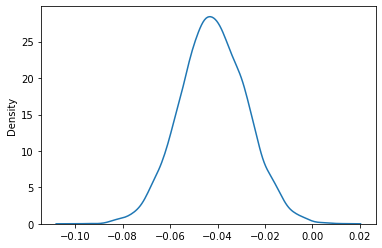

In [128]:
import seaborn as sns
sns.distplot(prior_dist_HC_1, hist=False)


In [129]:
prior_dist_HC_0 = []
for ii in range (10000):
    node7.parents['a'].parents['args'][1].random()
    prior_dist_HC_0.append(node7.parents['a'].parents['args'][1].value.item())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


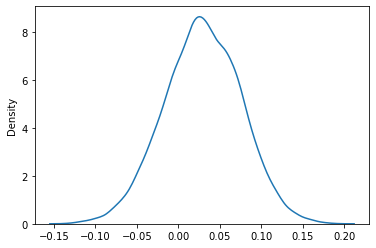

In [130]:
import seaborn as sns
sns.distplot(prior_dist_HC_0, hist=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2820d202d0>,
      dtype=object)

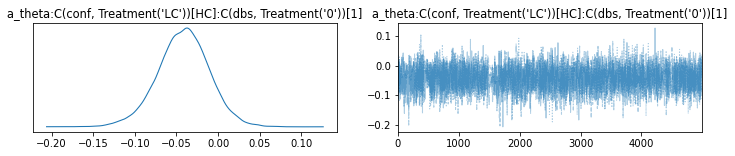

In [112]:
az.plot_trace(InfData['ms7'], var_names=(["a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]"]),
              combined = True)

#### Stochastics

We can also get the summary of stochastics as below. For the values of each draw in MCMC, we need go the traces.

A major difference between `observed` and `stochastics` lies in the trace()

In [133]:
iter_data2_tmp7 = ((name7, ms7_tmp.data.loc[obs7['node'].value.index]) for name7, obs7 in ms7_tmp.iter_group_nodes())
iter_data2_tmp7

<generator object <genexpr> at 0x7f27bd13f650>

In [136]:
group_nodes = {}
for name7, node7 in ms7_tmp.iter_group_nodes():
    print(name7)
    group_nodes[name7] = node7
#     node7 = ms7_tmp.get_data_nodes(data7.index) # get the node corresponding to data.index.
# print(name7)
# node7

t
t_std
sv
sz
st
z_trans
z_std
a_Intercept
a_Intercept_std
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_std
a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]
a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_std
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_std
a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]
a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]_std
v_Intercept
v_Intercept_std
v_C(conf, Treatment('LC'))[T.HC]
v_C(conf, Treatment('LC'))[T.HC]_std


In [137]:
tmp_x  = group_nodes["a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]"]
tmp_x

knode_name    a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Tr...
stochastic                                                 True
observed                                                  False
subj                                                      False
node          a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Tr...
tag                                                          ()
depends                                                      []
hidden                                                    False
subj_idx                                                    NaN
stim                                                        NaN
rt                                                          NaN
response                                                    NaN
theta                                                       NaN
dbs                                                         NaN
conf                                                        NaN
mean                                    

In [138]:
tmp_x.node

<pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]' at 0x7f2820ff48d0>

In [159]:
tmp_posterior = tmp_x.node.trace()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


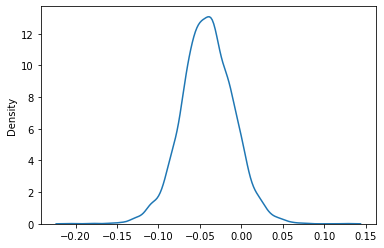

In [160]:
sns.distplot(tmp_posterior, hist=False)

In [139]:
tmp_x.node.parents

{'mu': 0, 'tau': 0.0044444444444444444}

In [150]:
tmp_x1  = group_nodes["a_Intercept"]
tmp_x1.node.parents

{'alpha': 4.0, 'beta': 2.6666666666666665}

In [144]:
tmp_x2  = group_nodes["a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_std"]
tmp_x2

knode_name    a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Tr...
stochastic                                                 True
observed                                                  False
subj                                                      False
node          a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Tr...
tag                                                          ()
depends                                                      []
hidden                                                    False
subj_idx                                                    NaN
stim                                                        NaN
rt                                                          NaN
response                                                    NaN
theta                                                       NaN
dbs                                                         NaN
conf                                                        NaN
mean                                    

In [145]:
tmp_x2.node.parents

{'lower': 1e-10, 'upper': 100}

In [75]:
ms2_tmp.get_stochastics()

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,stim,...,dbs,conf,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,a,True,False,False,a,(),[],False,NaN,NaN,...,NaN,NaN,1.8367,0.108995,1.6329,1.76458,1.83338,1.90323,2.0665,0.00157731
a_std,a_std,True,False,False,a_std,(),[],False,NaN,NaN,...,NaN,NaN,0.382772,0.0914767,0.249137,0.319499,0.367574,0.428863,0.607078,0.00145429
a_subj.0,a_subj,True,False,True,a_subj.0,(),[subj_idx],False,0,NaN,...,NaN,NaN,2.04668,0.0698414,1.91653,1.99923,2.04351,2.09305,2.18668,0.00107978
a_subj.1,a_subj,True,False,True,a_subj.1,(),[subj_idx],False,1,NaN,...,NaN,NaN,1.98133,0.0788434,1.83714,1.92518,1.97744,2.03313,2.14206,0.0015177
a_subj.2,a_subj,True,False,True,a_subj.2,(),[subj_idx],False,2,NaN,...,NaN,NaN,1.39642,0.0548526,1.2939,1.35856,1.3942,1.43176,1.50879,0.00101751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z_subj_trans.9,z_subj_trans,True,False,True,z_subj_trans.9,(),[subj_idx],True,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z_subj_trans.10,z_subj_trans,True,False,True,z_subj_trans.10,(),[subj_idx],True,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z_subj_trans.11,z_subj_trans,True,False,True,z_subj_trans.11,(),[subj_idx],True,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z_subj_trans.12,z_subj_trans,True,False,True,z_subj_trans.12,(),[subj_idx],True,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
def draw_slope_prior(value=0, g_mu=None, g_tau=15**-2, std_lower=1e-10, 
                     std_upper=100, std_value=.1, size=1):
    '''
    draw parameter a from its prior
    refer: hddm/models/base.py#L310
    return three parameters: sampled value (group value), group mu, and group std
    '''
    import numpy as np

    if g_mu is None:
        g_mu = value
    
    mu = np.random.normal(g_mu, np.sqrt(1 / g_tau), size=size)
    std = np.random.uniform(std_lower, std_upper, size=size)
    
    sample_value = np.random.normal(mu, std, size=size)

    return sample_value, mu, std

In [192]:
np.sqrt(1/(15**-2))

15.0

In [157]:
prior_dist_HC_0, _, _ = draw_slope_prior(size=5000)

In [166]:
prior_dist_HC_0_2 = np.random.uniform(0, 0.3, size=5000)

In [161]:
len(prior_dist_HC_0)

5000

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


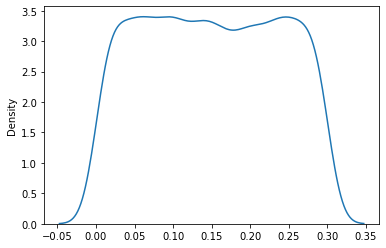

In [167]:
sns.distplot(prior_dist_HC_0_2, hist=False)

In [168]:
df_HC_0 = pd.DataFrame({'prior_def': prior_dist_HC_0,
                        'prior_inf': prior_dist_HC_0_2,
                        'posterior': tmp_posterior}, 
                       columns=['prior_def', 'prior_inf', 'posterior'])
df_HC_0

,prior_def,prior_inf,posterior
0,-10.041525,0.238282,-0.033221
1,-35.500886,0.048873,-0.079166
2,52.104482,0.196828,-0.111570
3,-18.599431,0.265539,-0.095639
4,-109.718751,0.232893,-0.069358
...,...,...,...
4995,1.430142,0.258903,-0.036898
4996,-53.029248,0.165223,-0.024278
4997,9.388550,0.159695,-0.022490
4998,-44.964336,0.014396,-0.030676


In [169]:
df_HC_0.to_csv('df_HC_0_bf.csv', index=False)

In [193]:
import seaborn as sns

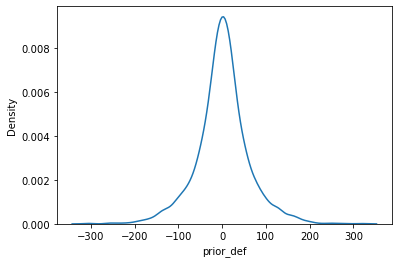

In [194]:
sns.kdeplot(data=df_HC_0, x="prior_def")

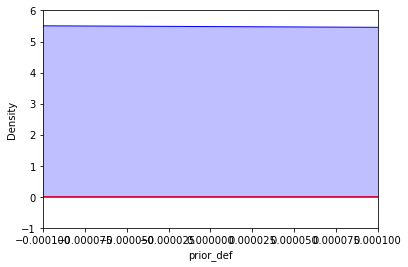

In [210]:
plt.xlim(-0.0001, 0.0001)
plt.ylim(-1, 6)
fig = sns.kdeplot(df_HC_0['prior_def'], shade=False, color="r")
fig = sns.kdeplot(df_HC_0['posterior'], shade=True, color="b")
plt.show()

In [189]:
import scipy.stats as stats
kde_prior_def = stats.gaussian_kde(df_HC_0['prior_def'])
kde_prior_inf = stats.gaussian_kde(df_HC_0['prior_inf'])
kde_posterior = stats.gaussian_kde(df_HC_0['posterior'])

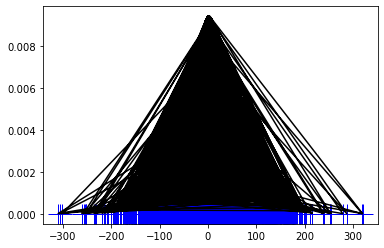

In [179]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.plot(df_HC_0['prior_def'], np.zeros(df_HC_0['prior_def'].shape), 'b+', ms=20)  # rug plot

x_eval = np.linspace(-300, 300, num=600)

ax.plot(df_HC_0['prior_def'], kde_prior_def(df_HC_0['prior_def']), 'k-', label="Scott's Rule")

# ax.plot(x_eval, kde2(x_eval), 'r-', label="Silverman's Rule")

In [182]:
kde_prior_def(df_HC_0['prior_def']).sum()

28.39702257900283

In [185]:
kde_prior_def.integrate_box_1d( -0.004, 0.004)

7.520327805126877e-05

In [190]:
print('PDF of default prior: ', kde_prior_def.pdf(0))
print('PDF of informed prior: ', kde_prior_inf.pdf(0))
print('PDF of posterior: ', kde_posterior.pdf(0))

PDF of default prior:  [0.00940041]
PDF of informed prior:  [1.62651929]
PDF of posterior:  [5.48253573]


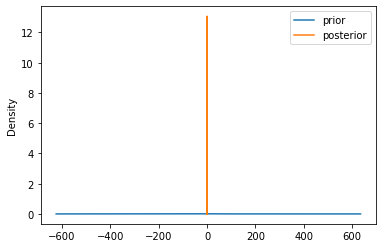

In [163]:
ax = df_HC_0.plot.kde()

When using `.get_traces()`, we can extract the MCMC samples (traces) of the stochastic variables.

In [77]:
ms2_tmp_traces = ms2_tmp.get_traces()
ms2_tmp_traces.columns

Index(['a', 'a_std', 'a_subj.0', 'a_subj.1', 'a_subj.2', 'a_subj.3',
       'a_subj.4', 'a_subj.5', 'a_subj.6', 'a_subj.7', 'a_subj.8', 'a_subj.9',
       'a_subj.10', 'a_subj.11', 'a_subj.12', 'a_subj.13', 'v(HC)', 'v(LC)',
       'v_std', 'v_subj(HC).0', 'v_subj(HC).1', 'v_subj(HC).2', 'v_subj(HC).3',
       'v_subj(HC).4', 'v_subj(HC).5', 'v_subj(HC).6', 'v_subj(HC).7',
       'v_subj(HC).8', 'v_subj(HC).9', 'v_subj(HC).10', 'v_subj(HC).11',
       'v_subj(HC).12', 'v_subj(HC).13', 'v_subj(LC).0', 'v_subj(LC).1',
       'v_subj(LC).2', 'v_subj(LC).3', 'v_subj(LC).4', 'v_subj(LC).5',
       'v_subj(LC).6', 'v_subj(LC).7', 'v_subj(LC).8', 'v_subj(LC).9',
       'v_subj(LC).10', 'v_subj(LC).11', 'v_subj(LC).12', 'v_subj(LC).13', 't',
       't_std', 't_subj.0', 't_subj.1', 't_subj.2', 't_subj.3', 't_subj.4',
       't_subj.5', 't_subj.6', 't_subj.7', 't_subj.8', 't_subj.9', 't_subj.10',
       't_subj.11', 't_subj.12', 't_subj.13', 'sv', 'sz', 'st', 'z_trans',
       'z_std', 'z_subj_t

In the same vein, we can check the stochastic variables. 

In [78]:
iter_data_tmp2_s = ((name2, stc2) for name2, stc2 in ms2_tmp.iter_stochastics())
iter_data_tmp2_s
iter_data_tmp7_s = ((name7, stc7) for name7, stc7 in ms7_tmp.iter_stochastics())
iter_data_tmp7_s

<generator object <genexpr> at 0x7f2804d1ab50>

In [79]:
for name2, stc2 in iter_data_tmp2_s:
#     print(name)
#     node2_s = stc2 # get the node corresponding to data.index.
    print("Name of the node: ", name2)
    print("Parents' value: ", stc2.node.parents.value)
    print("Value of the node: ", stc2.node.value, '\n')
# print(name2)

Name of the node:  a
Parents' value:  {'alpha': 4.0, 'beta': 2.6666666666666665}
Value of the node:  1.6735424484603376 

Name of the node:  a_std
Parents' value:  {'tau': 0.25}
Value of the node:  0.4177886779820643 

Name of the node:  a_subj.0
Parents' value:  {'alpha': 16.045754084786434, 'beta': 9.587897874684062}
Value of the node:  2.0066927360358693 

Name of the node:  a_subj.1
Parents' value:  {'alpha': 16.045754084786434, 'beta': 9.587897874684062}
Value of the node:  1.9016928600128526 

Name of the node:  a_subj.2
Parents' value:  {'alpha': 16.045754084786434, 'beta': 9.587897874684062}
Value of the node:  1.4236061607098542 

Name of the node:  a_subj.3
Parents' value:  {'alpha': 16.045754084786434, 'beta': 9.587897874684062}
Value of the node:  2.0421031112029135 

Name of the node:  a_subj.4
Parents' value:  {'alpha': 16.045754084786434, 'beta': 9.587897874684062}
Value of the node:  1.2597158677066014 

Name of the node:  a_subj.5
Parents' value:  {'alpha': 16.04575408

In [80]:
ms2_tmp['a'].parents['alpha']

4.0

In [81]:
stc2.node.parents['mu'].parents

{'mu': 0.0, 'tau': 4.0}

In [83]:
stc2.node.parents['mu'].trace()

array([ 0.12085014,  0.04266693, -0.03299219, ...,  0.07278604,
        0.06583031,  0.10598918])

In [89]:
node2.parents['a'].parents['alpha'].trace()

In [86]:
stc2.node

<pymc.distributions.new_dist_class.<locals>.new_class 'z_subj_trans.13' at 0x7f28226c62d0>

In [71]:
for name7, stc7 in iter_data_tmp7_s:
    print(name7)
    print(stc7.node.parents.value) # get the node corresponding to data.index.
# print(name7)

t
{'alpha': 4.0, 'beta': 9.999999999999998}
t_std
{'tau': 1.0}
t_subj.0
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.1
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.2
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.3
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.4
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.5
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.6
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.7
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.8
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.9
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.10
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.11
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.12
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
t_subj.13
{'alpha': 24.192361649073277, 'beta': 39.87594695380462}
sv
{'tau'

However, the stochastic nodes has different properties as the `observed`. We can check the fields of stochastic objects

In [27]:
node2_s

knode_name       z_subj_trans
stochastic               True
observed                False
subj                     True
node          z_subj_trans.13
tag                        ()
depends            [subj_idx]
hidden                   True
subj_idx                   13
stim                      NaN
rt                        NaN
response                  NaN
theta                     NaN
dbs                       NaN
conf                      NaN
mean                      NaN
std                       NaN
2.5q                      NaN
25q                       NaN
50q                       NaN
75q                       NaN
97.5q                     NaN
mc err                    NaN
Name: z_subj_trans.13, dtype: object

We can see that it has `node`, "z_subj_trans.13", which we can check for more details and compared to `observed` node.

In [35]:
node2_s.knode_name

'z_subj_trans'

In [34]:
node2_s.name

'z_subj_trans.13'

In [28]:
node2_s.node

<pymc.distributions.new_dist_class.<locals>.new_class 'z_subj_trans.13' at 0x7f15dcaca350>

In [29]:
node2_s.node.children

{<pymc.CommonDeterministics.InvLogit 'z_subj.13' at 0x7f15dca6e9d0>}

In [30]:
for ii in node2_s.node.children:
    print(ii, "'s value: ", ii.value)
#     ii.value

z_subj.13 's value:  0.5094225529719416


In [31]:
node2_s.node.parents

{'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'z_trans' at 0x7f15dcd23ad0>,
 'tau': <pymc.PyMCObjects.Deterministic 'z_tau' at 0x7f15dcce8550>}

In [32]:
node2_s.node.parents.value

{'mu': array(0.10598918), 'tau': 577.5421812759332}

In [40]:
node7_s.node.parents.value

{'mu': array(-0.52898988), 'tau': 55.940801353599674}

In [37]:
tmp7 = ms7_tmp.get_stochastics()
type(tmp7)

pandas.core.frame.DataFrame

In [39]:
tmp7 = ms7_tmp.get_subj_nodes()
type(tmp7)

pandas.core.frame.DataFrame

In [211]:
from prior_pred_gen import _parents_to_posterior_sample
from prior_pred_gen import _PP_generate
from prior_pred_gen import prior_pred_gen

In [212]:
models

{'ms2': [<hddm.models.hddm_info.HDDM at 0x7f2822a96650>,
 'ms7': [<hddm.models.hddm_regression.HDDMRegressor at 0x7f2821fafa90>,
  <hddm.models.hddm_regression.HDDMRegressor at 0x7f281b7167d0>]}

In [213]:
prior_tmp2 = prior_pred_gen(models['ms2'][0], samples = nppc)

 [-------------------110%-------------------] 31 of 28 complete in 1501.5 sec

In [ ]:
df_prior_pred_tmp = p_map(partial(prior_pred_gen, samples = nppc), models['ms2'])

In [59]:
def draw_from_prior_new(m, update=False):
    from copy import copy
    if not update:
        values = m.values

    non_zero = True
    while non_zero:
        try:
            m.mc.draw_from_prior()
            m.mc.logp
            draw = copy(m.values)
            non_zero = False
        except pm.ZeroProbability:
            non_zero = True

    if not update:
        # restore original values
        # m.set_values(values)
        for (name, value) in new_values.items():
        #     print(name, value)
        #     print(ms7_tmp.nodes_db.loc[name]['node'], type(ms7_tmp.nodes_db.loc[name]['node']))
            if isinstance(ms7_tmp.nodes_db.loc[name]['node'], pm.Deterministic):
                ms7_tmp.nodes_db.loc[name]['node'].get_value()
            else:
                ms7_tmp.nodes_db.loc[name]['node'].set_value(value)

    return draw

In [60]:
draw_tmp = draw_from_prior_new(ms7_tmp)
draw_tmp

OrderedDict([('t', 0.5067742885942773),
             ('t_std', 0.5340818469233026),
             ('t_rate', 1.7766379676434978),
             ('t_shape', 0.9003544421421161),
             ('t_subj.0', 0.417701195813297),
             ('t_subj.1', 0.8197575213968907),
             ('t_subj.2', 0.49284801015796875),
             ('t_subj.3', 1.2572486389087947),
             ('t_subj.4', 0.3959099304568244),
             ('t_subj.5', 0.30388022229927797),
             ('t_subj.6', 1.7615637032732427),
             ('t_subj.7', 0.3338636284513435),
             ('t_subj.8', 0.3088759183115513),
             ('t_subj.9', 0.34856070498433134),
             ('t_subj.10', 0.0678136240907472),
             ('t_subj.11', 0.003565433073263536),
             ('t_subj.12', 0.35668951907885127),
             ('t_subj.13', 0.33237186902863314),
             ('sv', 0.9955629505115097),
             ('sz', 0.29162178058561955),
             ('st', 0.2983214948019027),
             ('z_trans', 0.905461

In [41]:
ms7_tmp.draw_from_prior()

AttributeError: Deterministic t_rate's value cannot be set.

In [42]:
ms7_tmp.values

OrderedDict([('t', 0.6066905866110108),
             ('t_std', 0.12334686715058127),
             ('t_rate', 39.87594695380462),
             ('t_shape', 24.192361649073277),
             ('t_subj.0', 0.3016868471584889),
             ('t_subj.1', 0.4661019498235691),
             ('t_subj.2', 0.1570213481847324),
             ('t_subj.3', 0.517764432510146),
             ('t_subj.4', 0.7113798839214698),
             ('t_subj.5', 0.16769518327670088),
             ('t_subj.6', 0.6890639854069633),
             ('t_subj.7', 0.34453026407188253),
             ('t_subj.8', 0.16374087631974923),
             ('t_subj.9', 0.7400372645985804),
             ('t_subj.10', 0.11466656073793141),
             ('t_subj.11', 0.9484545654917707),
             ('t_subj.12', 0.8821342765740839),
             ('t_subj.13', 0.2141607697524477),
             ('sv', 2.7251743519645713),
             ('sz', 0.0525327685166204),
             ('st', 0.24178342574766337),
             ('z_trans', 0.118235727

In [48]:
isinstance(ms7_tmp.nodes_db.loc['t_rate']['node'], pm.Deterministic)

True

In [53]:
ms7_tmp.nodes_db.loc['t_rate']['node'].get_value()

39.87594695380462

In [50]:
isinstance(ms7_tmp.nodes_db.loc['t_std']['node'], pm.Stochastic)

True

In [55]:
new_values = ms7_tmp.values
for (name, value) in new_values.items():
#     print(name, value)
#     print(ms7_tmp.nodes_db.loc[name]['node'], type(ms7_tmp.nodes_db.loc[name]['node']))
    if isinstance(ms7_tmp.nodes_db.loc[name]['node'], pm.Deterministic):
        ms7_tmp.nodes_db.loc[name]['node'].get_value()
    else:
        ms7_tmp.nodes_db.loc[name]['node'].set_value(value)

In [12]:
from post_pred_gen_redifined import _parents_to_random_posterior_sample
from post_pred_gen_redifined import _post_pred_generate
from post_pred_gen_redifined import post_pred_gen

from pointwise_loglik_gen import _pointwise_like_generate
from pointwise_loglik_gen import pointwise_like_gen

In [15]:
for name7, data7 in iter_data_tmp7:
    print(name7)
    node7 = ms7_tmp.get_data_nodes(data7.index) # get the node corresponding to data.index.
    # node
    
    for i, parent in enumerate(node7.extended_parents):
        if name5 == 'wfpt.13':
            print("Order of extended_parent: ", i)
            print(parent)

wfpt(HC).0
wfpt(HC).1
wfpt(HC).2
wfpt(HC).3
wfpt(HC).4
wfpt(HC).5
wfpt(HC).6
wfpt(HC).7
wfpt(HC).8
wfpt(HC).9
wfpt(HC).10
wfpt(HC).11
wfpt(HC).12
wfpt(HC).13
wfpt(LC).0
wfpt(LC).1
wfpt(LC).2
wfpt(LC).3
wfpt(LC).4
wfpt(LC).5
wfpt(LC).6
wfpt(LC).7
wfpt(LC).8
wfpt(LC).9
wfpt(LC).10
wfpt(LC).11
wfpt(LC).12
wfpt(LC).13


In [16]:
df_pll_tmp2 = _pointwise_like_generate(node2_HC, samples=None, data=None, append_data=False)
df_pll_tmp2 = pd.concat(df_pll_tmp2, names=['draw'], 
                            keys = list(range(len(df_pll_tmp2))))
df_pll_tmp2

log_lik
draw trial_idx          
0    0         -0.775333
     2         -0.881349
     4         -1.246707
     6         -1.674462
     8         -1.373326
...                  ...
1499 290       -1.862179
     291       -1.103772
     292       -2.511639
     295       -1.094928
     297       -1.362486

[220500 rows x 1 columns]

In [22]:
df_pll_tmp2

log_lik
draw trial_idx          
0    0         -0.775333
     2         -0.881349
     4         -1.246707
     6         -1.674462
     8         -1.373326
...                  ...
1499 290       -1.862179
     291       -1.103772
     292       -2.511639
     295       -1.094928
     297       -1.362486

[220500 rows x 1 columns]

In [24]:
pingInfoFilePath = "./df_pll_tmp2.ftr"
df_pll_tmp2.reset_index().to_feather(pingInfoFilePath)

In [25]:
readFrame = pd.read_feather(pingInfoFilePath, columns=None, use_threads=True)
readFrame

,draw,trial_idx,log_lik
0,0,0,-0.775333
1,0,2,-0.881349
2,0,4,-1.246707
3,0,6,-1.674462
4,0,8,-1.373326
...,...,...,...
220495,1499,290,-1.862179
220496,1499,291,-1.103772
220497,1499,292,-2.511639
220498,1499,295,-1.094928


In [17]:
df_pll_tmp5 = _pointwise_like_generate(node5, samples=None, data=None, append_data=False)
df_pll_tmp5 = pd.concat(df_pll_tmp5, names=['draw'], 
                            keys = list(range(len(df_pll_tmp5))))
df_pll_tmp5

log_lik
draw trial_idx          
0    3715      -0.663994
     3716      -1.433283
     3718      -1.373292
     3719      -2.307738
     3724      -1.883402
...                  ...
1499 3979      -1.127020
     3980      -1.395583
     3981      -1.040972
     3984      -1.775895
     3985      -1.290399

[202500 rows x 1 columns]

In [18]:
np.isinf(df_pll_tmp5).values.sum()

0

In [22]:
datasets = []

##############################
# Iterate the posterior and generate likelihood for each data point

for i, parent in enumerate(node5.extended_parents):
    if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
        continue
    else:
        mc_len = len(parent.trace())
        break
# # samples=samples
# if samples is None:
#     samples = mc_len
#     # print("Number of samples is equal to length of MCMC trace.")

# assert samples, "Can not determine the number of samples"
                

In [25]:
bottom_node = node5
for sample in range(mc_len):
    _parents_to_random_posterior_sample(bottom_node, pos = sample)

    param_dict = deepcopy(bottom_node.parents.value)

    # for regressor models
    if 'reg_outcomes' in param_dict:
        del param_dict['reg_outcomes']

        pointwise_lik = bottom_node.value.copy()
        pointwise_lik.index.names = ['trial_idx']        # change the index label as "trial_idx"
        pointwise_lik.drop(['rt'],axis=1,inplace=True) # drop 'rt' b/c not gonna use it.

        for i in bottom_node.value.index:
            # get current params
            for p in bottom_node.parents['reg_outcomes']:
                param_dict[p] = bottom_node.parents.value[p].loc[i].item()

            # calculate the point-wise likelihood.
            tmp_lik = hddm.wfpt.pdf_array(x = np.array(bottom_node.value.loc[i]),
                                          v = np.array(param_dict['v']),
                                           a = np.array(param_dict['a']), 
                                           t = np.array(param_dict['t']),
                                           p_outlier = param_dict['p_outlier'],
                                           sv = param_dict['sv'],
                                           z = param_dict['z'],
                                           sz = param_dict['sz'],
                                           st = param_dict['st'])
            pointwise_lik.loc[i, 'log_lik'] = tmp_lik

        # check if there is zero prob.
        if 0 in pointwise_lik.values:
            pointwise_lik['log_lik']=pointwise_lik['log_lik'].replace(0.0, pointwise_lik['log_lik'].mean())

        elif pointwise_lik['log_lik'].isnull().values.any():
            print('NAN in the likelihood, check the data !')
            break

        pointwise_lik['log_lik'] = np.log(pointwise_lik['log_lik'])
        
        if np.isinf(pointwise_lik['log_lik']).values.sum() > 0:
            print('Correction does not work!!!\n')

In [81]:
%%time
0 in pointwise_lik.values

CPU times: user 63 µs, sys: 2 µs, total: 65 µs
Wall time: 68.2 µs


False

In [78]:
%%time
np.isinf(pointwise_lik['log_lik']).values.sum() > 0

CPU times: user 533 µs, sys: 0 ns, total: 533 µs
Wall time: 551 µs


False

In [35]:
%%time
pointwise_lik.isnull().sum().sum() > 0

CPU times: user 529 µs, sys: 14 µs, total: 543 µs
Wall time: 520 µs


False

In [31]:
%%time
pointwise_lik.isnull().values.any()

CPU times: user 381 µs, sys: 10 µs, total: 391 µs
Wall time: 364 µs


False

In [38]:
%%time
pointwise_lik['log_lik'].isnull().values.any()

CPU times: user 639 µs, sys: 17 µs, total: 656 µs
Wall time: 678 µs


False

In [34]:
%%time
pointwise_lik['log_lik'].isnull().sum() > 0

CPU times: user 2.27 ms, sys: 0 ns, total: 2.27 ms
Wall time: 1.73 ms


False

In [19]:
tmp5 = df_pll_tmp2[df_pll_tmp2.isna().any(axis=1)]
tmp5

,,log_lik
draw,trial_idx,


In [18]:
np.isinf(df_pll_tmp2).values.sum()

0

In [13]:
df_pll_2 = p_map(partial(pointwise_like_gen), models['ms2'])

 [-----            14%                  ] 4 of 28 complete in 1.2 sec[-----            14%                  ] 4 of 28 complete in 1.2 sec[-----            14%                  ] 4 of 28 complete in 1.2 sec[-----            14%                  ] 4 of 28 complete in 1.2 sec[------           17%                  ] 5 of 28 complete in 2.5 sec[------           17%                  ] 5 of 28 complete in 2.5 sec[------           17%                  ] 5 of 28 complete in 2.5 sec[------           17%                  ] 5 of 28 complete in 2.5 sec[--------         21%                  ] 6 of 28 complete in 3.8 sec[--------         21%                  ] 6 of 28 complete in 3.9 sec[--------         21%                  ] 6 of 28 complete in 3.9 sec[--------         21%                  ] 6 of 28 complete in 3.9 sec[---------        25%                  ] 7 of 28 complete in 5.1 sec[---------        25%                  ] 7 of 28 complete in 5.1 sec[---------        25%                  ] 7 of 2

In [16]:
df_pll_2 = pd.concat(df_pll_2, names=['draw'], keys=list(range(len(df_pll_2))))
df_pll_2.head()

log_lik
draw node       draw trial_idx          
0    wfpt(HC).0 0    0         -0.775333
                     2         -0.881349
                     4         -1.246707
                     6         -1.674462
                     8         -1.373326

In each iterate, we can extract each node and check the parents,  extended_parents, and other properties of the nodes.

In [30]:
iter_data_tmp7

<generator object <genexpr> at 0x7f9ce94270d0>

In [21]:
node2_HC.value.index

Int64Index([  0,   2,   4,   6,   8,  10,  12,  13,  16,  20,
            ...
            281, 282, 285, 286, 287, 290, 291, 292, 295, 297],
           dtype='int64', length=147)

In [26]:
df_pll_2.iloc[df_pll_2.index.get_level_values('node') == "wfpt(HC).0"].index.get_level_values(3).unique()

Int64Index([  0,   2,   4,   6,   8,  10,  12,  13,  16,  20,
            ...
            281, 282, 285, 286, 287, 290, 291, 292, 295, 297],
           dtype='int64', name='trial_idx', length=147)

In [27]:
df_pll_2.iloc[df_pll_2.index.get_level_values('node') == "wfpt(HC).0"].index.get_level_values(3).unique() == node2_HC.value.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [15]:
index1 = node2_LC.value.index.array
index1

<PandasArray>
[  1,   3,   5,   7,   9,  11,  14,  15,  17,  18,
 ...
 275, 278, 280, 283, 284, 288, 289, 293, 294, 296]
Length: 151, dtype: int64

In [16]:
index2 = node2_HC.value.index.array
index2

<PandasArray>
[  0,   2,   4,   6,   8,  10,  12,  13,  16,  20,
 ...
 281, 282, 285, 286, 287, 290, 291, 292, 295, 297]
Length: 147, dtype: int64

In [17]:
any(x in set(index2) for x in index1)

False

In [18]:
df_ppc_2_sub0_HC = _post_pred_generate(node2_HC,samples=None, data=None, append_data=False)

Number of samples is equal to length of MCMC trace.


In [19]:
df_ppc_2_sub0_LC = _post_pred_generate(node2_LC,samples=None, data=None, append_data=False)

Number of samples is equal to length of MCMC trace.


In [20]:
df_ppc_2_sub0_HC = pd.concat(df_ppc_2_sub0_HC, names=['draw'], 
                             keys=list(range(len(df_ppc_2_sub0_HC))))  
df_ppc_2_sub0_HC.head()

rt  response
draw trial_idx                    
0    0         -1.007522       0.0
     2          0.931868       1.0
     4         -1.206423       0.0
     6          1.649377       1.0
     8         -1.440006       0.0

In [21]:
df_ppc_2_sub0_LC = pd.concat(df_ppc_2_sub0_LC, names=['draw'], 
                             keys=list(range(len(df_ppc_2_sub0_LC))))  
df_ppc_2_sub0_LC.head()

rt  response
draw trial_idx                    
0    1          1.179023       1.0
     3          4.129387       1.0
     5         -2.164839       0.0
     7         -0.955270       0.0
     9          1.024792       1.0

In [22]:
node2_HC.value.index

Int64Index([  0,   2,   4,   6,   8,  10,  12,  13,  16,  20,
            ...
            281, 282, 285, 286, 287, 290, 291, 292, 295, 297],
           dtype='int64', name='trial_idx', length=147)

In [23]:
df_ppc_2_sub0_HC.index

MultiIndex([(   0,   0),
            (   0,   2),
            (   0,   4),
            (   0,   6),
            (   0,   8),
            (   0,  10),
            (   0,  12),
            (   0,  13),
            (   0,  16),
            (   0,  20),
            ...
            (1499, 281),
            (1499, 282),
            (1499, 285),
            (1499, 286),
            (1499, 287),
            (1499, 290),
            (1499, 291),
            (1499, 292),
            (1499, 295),
            (1499, 297)],
           names=['draw', 'trial_idx'], length=220500)

In [24]:
node2_HC.value.index == df_ppc_2_sub0_HC.index.get_level_values(1).unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [25]:
node2_LC.value.index

Int64Index([  1,   3,   5,   7,   9,  11,  14,  15,  17,  18,
            ...
            275, 278, 280, 283, 284, 288, 289, 293, 294, 296],
           dtype='int64', name='trial_idx', length=151)

In [26]:
df_ppc_2_sub0_LC.index

MultiIndex([(   0,   1),
            (   0,   3),
            (   0,   5),
            (   0,   7),
            (   0,   9),
            (   0,  11),
            (   0,  14),
            (   0,  15),
            (   0,  17),
            (   0,  18),
            ...
            (1499, 275),
            (1499, 278),
            (1499, 280),
            (1499, 283),
            (1499, 284),
            (1499, 288),
            (1499, 289),
            (1499, 293),
            (1499, 294),
            (1499, 296)],
           names=['draw', 'trial_idx'], length=226500)

In [27]:
df_ppc_2_sub0_LC.index.get_level_values(1).unique()

Int64Index([  1,   3,   5,   7,   9,  11,  14,  15,  17,  18,
            ...
            275, 278, 280, 283, 284, 288, 289, 293, 294, 296],
           dtype='int64', name='trial_idx', length=151)

In [28]:
node2_LC.value.index == df_ppc_2_sub0_LC.index.get_level_values(1).unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [38]:
import pymc as pm
import numpy as np


datasets = []

In [39]:
for i, parent in enumerate(node2_HC.extended_parents):
    if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
        continue
    else:
        mc_len = len(parent.trace())
        break

# samples=samples
if samples is None:

    samples = mc_len
    print("Number of samples is equal to length of MCMC trace.")


In [43]:
samples = mc_len
samples

1500

In [45]:
# assert samples, "Can not determine the number of samples"

# for sample in range(samples):

sample = 0

_parents_to_random_posterior_sample(node2_HC, pos = sample)

# Generate data from bottom node
sampled_data = node2_HC.random()


In [47]:
sampled_data

,rt,response
0,-2.276289,0.0
1,1.408459,1.0
2,1.482535,1.0
3,-1.013911,0.0
4,2.500801,1.0
...,...,...
142,2.714920,1.0
143,-1.305316,0.0
144,1.348555,1.0
145,-0.961198,0.0


In [48]:
node2_HC.value

,rt
0,1.210
2,1.030
4,-1.140
6,2.000
8,0.857
...,...
290,0.796
291,-1.230
292,2.600
295,-1.160


In [54]:
if not all(sampled_data.index == node2_HC.value.index):
    print("need to change index")

need to change index


In [ ]:
# change the index of ppc data if it is not the same as the observed data
if not any(sampled_data.index == bottom_node.value.index): 
    sampled_data.index = bottom_node.value.index

sampled_data.index.names = ['trial_idx']

# add the "response" column for regression models
if not "response" in sampled_data.columns:
    sampled_data["response"] = np.where(sampled_data['rt'] > 0, 1,
                                        np.where(sampled_data['rt'] <=0, 0, None)) 

if append_data and data is not None:
    sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
datasets.append(sampled_data)


In [13]:
for name5, data5 in iter_data_tmp5:
    print(name5)
    node5 = ms5_tmp.get_data_nodes(data5.index) # get the node corresponding to data.index.
    # node
    
    for i, parent in enumerate(node5.extended_parents):
        if name5 == 'wfpt.13':
            print("Order of extended_parent: ", i)
            print(parent)

wfpt(HC).0
wfpt(HC).1
wfpt(HC).2
wfpt(HC).3
wfpt(HC).4
wfpt(HC).5
wfpt(HC).6
wfpt(HC).7
wfpt(HC).8
wfpt(HC).9
wfpt(HC).10
wfpt(HC).11
wfpt(HC).12
wfpt(HC).13
wfpt(LC).0
wfpt(LC).1
wfpt(LC).2
wfpt(LC).3
wfpt(LC).4
wfpt(LC).5
wfpt(LC).6
wfpt(LC).7
wfpt(LC).8
wfpt(LC).9
wfpt(LC).10
wfpt(LC).11
wfpt(LC).12
wfpt(LC).13


In [14]:
node5.extended_parents

{<pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]_subj.13' at 0x7f10e1fe3d90>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'st' at 0x7f10e27e6b50>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7f10e2b9d950>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj(LC).13' at 0x7f10e2490a50>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[LC]_subj.13' at 0x7f10e2016250>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'sz' at 0x7f10e27e6250>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'z_subj_trans.13' at 0x7f10e2076810>,
 <pymc.distributions.new_dist_class.<locals>.new_class 't_subj.13' at 0x7f10e20a6a10>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_Intercept_subj.13' at 0x7f10e203fe10>}

In [15]:
for name7, data7 in iter_data_tmp7:
    print(name7)
    node7 = ms7_tmp.get_data_nodes(data7.index) # get the node corresponding to data.index.
    # node
    
    for i, parent in enumerate(node7.extended_parents):
        if name7 == 'wfpt.13':
            print("Order of extended_parent: ", i)
            print(parent)

wfpt.0
wfpt.1
wfpt.2
wfpt.3
wfpt.4
wfpt.5
wfpt.6
wfpt.7
wfpt.8
wfpt.9
wfpt.10
wfpt.11
wfpt.12
wfpt.13
Order of extended_parent:  0
sz
Order of extended_parent:  1
a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_subj.13
Order of extended_parent:  2
t_subj.13
Order of extended_parent:  3
a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]_subj.13
Order of extended_parent:  4
a_Intercept_subj.13
Order of extended_parent:  5
v_C(conf, Treatment('LC'))[T.HC]_subj.13
Order of extended_parent:  6
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.13
Order of extended_parent:  7
z_subj_trans.13
Order of extended_parent:  8
v_Intercept_subj.13
Order of extended_parent:  9
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_subj.13
Order of extended_parent:  10
st
Order of extended_parent:  11
sv


In [16]:
node7

<pymc.distributions.new_dist_class.<locals>.new_class 'wfpt.13' at 0x7fa75ef29d50>

In [19]:
datasets5 = _post_pred_generate(node5, samples=300, data=None, append_data=False)
datasets5

[                 rt response
 trial_idx                   
 3715       1.409273        1
 3716       3.763312        1
 3718       1.778683        1
 3719      -1.630310        0
 3724      -2.873457        0
 ...             ...      ...
 3979       0.841206        1
 3980       1.132463        1
 3981       1.821747        1
 3984      -1.413759        0
 3985       1.917863        1
 
 [135 rows x 2 columns],
                  rt response
 trial_idx                   
 3715       5.112616        1
 3716       1.241982        1
 3718       4.117038        1
 3719       1.711777        1
 3724       0.881426        1
 ...             ...      ...
 3979       3.148814        1
 3980      -1.394265        0
 3981       0.904401        1
 3984      -1.053935        0
 3985      -2.405205        0
 
 [135 rows x 2 columns],
                  rt response
 trial_idx                   
 3715       2.745060        1
 3716      -1.217427        0
 3718       1.518758        1
 3719       0.97

In [20]:
node5.random()

,rt
3715,0.767788
3716,1.717424
3718,1.214926
3719,-6.690742
3724,1.209056
...,...
3979,-0.906328
3980,2.040207
3981,1.008237
3984,2.835378


In [21]:
node5.value

,rt
3715,0.929
3716,1.880
3718,1.810
3719,-1.920
3724,2.300
...,...
3979,1.660
3980,1.890
3981,1.590
3984,0.711


In [20]:
datasets7 = _post_pred_generate(node7, samples=None, data=None, append_data=False)
datasets7

Number of samples is equal to length of MCMC trace.


[                 rt response
 trial_idx                   
 3714      -1.057788        0
 3715       1.681301        1
 3716       0.863445        1
 3717      -0.970333        0
 3718       1.359569        1
 ...             ...      ...
 3983       0.988109        1
 3984       1.110974        1
 3985       1.787548        1
 3986       1.742085        1
 3987      -2.064669        0
 
 [274 rows x 2 columns],
                  rt response
 trial_idx                   
 3714       1.177459        1
 3715       1.610119        1
 3716       1.373421        1
 3717       2.163059        1
 3718      -1.333076        0
 ...             ...      ...
 3983       1.245924        1
 3984      -1.661632        0
 3985       4.849354        1
 3986      -2.045702        0
 3987       2.765157        1
 
 [274 rows x 2 columns],
                  rt response
 trial_idx                   
 3714       1.685802        1
 3715       1.309598        1
 3716       1.638215        1
 3717       1.59

In [37]:
len(datasets7)

1500

In [24]:
datasets1 = _post_pred_generate(node, samples=None, data=None, append_data=False)

Number of samples is equal to length of MCMC trace.


In [25]:
datasets1

[                 rt  response
 trial_idx                    
 3714      -0.974782       0.0
 3715       1.777994       1.0
 3716       1.132826       1.0
 3717       3.440303       1.0
 3718       1.873888       1.0
 ...             ...       ...
 3983       1.550933       1.0
 3984      -2.223484       0.0
 3985       1.234439       1.0
 3986      -1.175953       0.0
 3987       0.713392       1.0
 
 [274 rows x 2 columns],
                  rt  response
 trial_idx                    
 3714      -5.891114       0.0
 3715      -2.205038       0.0
 3716      -1.243729       0.0
 3717      -1.968253       0.0
 3718       2.007208       1.0
 ...             ...       ...
 3983       1.732055       1.0
 3984      -2.586954       0.0
 3985      -1.933651       0.0
 3986       1.019084       1.0
 3987       1.487821       1.0
 
 [274 rows x 2 columns],
                  rt  response
 trial_idx                    
 3714       4.262569       1.0
 3715       2.294025       1.0
 3716      -1.65

In [ ]:
for name, data in iter_data:
    node = model.get_data_nodes(data.index)

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    if node is None or not hasattr(node, 'random'):
        continue # Skip

    ##############################
    # Sample and generate stats
    datasets = _post_pred_generate(node, samples=samples, data=data, append_data=append_data)
    results[name] = pd.concat(datasets, names=['draw'], keys=list(range(len(datasets))))

    # add the "response" column for regression models
    if not "response" in results.columns:
        results["response"] = np.where(results['rt'] > 0, 1, 
                                       np.where(results['rt'] <=0, 0, None)) 

After the iteration, we can see that `node` is the `wfpt.13`, the last element of `observeds`.

You can also check the input data of each node.

In [13]:
isinstance(node, pm.Node) # check if the node is a pymc node.

True

In [23]:
node.value

,rt
3714,1.500
3715,0.929
3716,1.880
3717,-1.180
3718,1.810
...,...
3983,-1.450
3984,0.711
3985,0.784
3986,-2.350


Or node's name

In [15]:
node.__name__

'wfpt.13'

In [ ]:
# get the subject id
data['subj_idx'].loc[node.value.index].unique()

In [16]:
node.parents

{'p_outlier': 0.05,
 'v': <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj.13' at 0x7f6dc5737750>,
 'sv': <pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7f6dc58da8d0>,
 'a': <pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.13' at 0x7f6dc57755d0>,
 'z': <pymc.CommonDeterministics.InvLogit 'z_subj.13' at 0x7f6dc56dce90>,
 'sz': <pymc.distributions.new_dist_class.<locals>.new_class 'sz' at 0x7f6dc58daf50>,
 't': <pymc.distributions.new_dist_class.<locals>.new_class 't_subj.13' at 0x7f6dc56e5ed0>,
 'st': <pymc.distributions.new_dist_class.<locals>.new_class 'st' at 0x7f6dc58e5b50>}

In [17]:
node.parents.value

{'v': array(0.19225226),
 'sv': array(0.12883454),
 'a': array(2.06162401),
 'z': array(0.52247385),
 'sz': array(0.1526342),
 't': array(0.67963306),
 'st': array(0.46497784),
 'p_outlier': 0.05}

In [18]:
node.extended_parents

{<pymc.distributions.new_dist_class.<locals>.new_class 'a_subj.13' at 0x7f6dc57755d0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'st' at 0x7f6dc58e5b50>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_subj.13' at 0x7f6dc5737750>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'sz' at 0x7f6dc58daf50>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7f6dc58da8d0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 't_subj.13' at 0x7f6dc56e5ed0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'z_subj_trans.13' at 0x7f6dc56b2850>}

Note, extended_parents do not have value

And as we said, `random()` function of the node can be used to generate random values based on the **current** parents' value. You can re-run the code below for a few times, see how the value of RT changes each time.

In [23]:
sampled_data = node.random()
sampled_data

,rt,response
0,2.428942,1.0
1,2.983670,1.0
2,1.884258,1.0
3,1.753909,1.0
4,-1.048085,0.0
...,...,...
269,1.079058,1.0
270,1.983772,1.0
271,2.122878,1.0
272,4.829852,1.0


In [25]:
sample_data7 = node7.random()

In [30]:
not any(sampled_data.index == node.value.index)

True

In [29]:
any(sample_data7.index == node7.value.index)

True

In [22]:
node.random()

,rt,response
0,1.396042,1.0
1,1.154437,1.0
2,0.742758,1.0
3,3.109260,1.0
4,-1.481202,0.0
...,...,...
269,1.601240,1.0
270,-0.907861,0.0
271,1.067648,1.0
272,2.201136,1.0


Very conveniently, we can directly retriviel the traces of a node's parents and extended_parent here too.

In [20]:
node.parents['v'].trace()

array([0.15387324, 0.21610853, 0.1367186 , ..., 0.18279531, 0.19987589,
       0.19225226])

In [25]:
# we can not directly index extended_parents but can get the trace in a for loop
for i, parent in enumerate(node.extended_parents):
    print(parent)
    print(parent.trace())

st
[0.45661132 0.45625829 0.48352744 ... 0.51125925 0.52033121 0.47464767]
a_Intercept_subj.13
[2.14894803 2.04464093 2.24554997 ... 2.2302547  2.19780888 2.0290853 ]
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_subj.13
[ 0.12125852  0.19985113  0.0641674  ... -0.01330511  0.09896035
  0.09104917]
a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_subj.13
[-0.06125472 -0.0779277  -0.04243819 ...  0.04367235  0.05348451
  0.10372685]
sv
[0.21481978 0.2732277  0.24124355 ... 0.25024603 0.29303582 0.25823629]
a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]_subj.13
[ 0.03394697 -0.11044463 -0.05594438 ...  0.03232501 -0.00100048
 -0.00782412]
v_C(conf, Treatment('LC'))[T.HC]_subj.13
[-0.51252481 -0.47892954 -0.48017478 ... -0.52627411 -0.49826299
 -0.47897617]
sz
[0.220693   0.19928462 0.14847611 ... 0.13398106 0.02876901 0.13495805]
a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.13
[-0.03347591 -0.01104332  0.01372463 ...  

In [33]:
def _post_pred_generate(bottom_node, samples=None, data=None, append_data=False):
    """Generate posterior predictive data from a single observed node."""
    import pymc as pm
    import numpy as np
    
    
    datasets = []

    ##############################
    # Sample and generate stats
    # If number of samples is fixed, use the original code, i.e., randomly sample one set of
    # values from extended_parents and generate random value;
    #
    # If number of samples is None, use the lenght of trace, and iterate the whole posterior.

    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue
        else:
            mc_len = len(parent.trace())
            break

    # samples=samples
    if samples is None:

        samples = mc_len
        print("Number of samples is equal to length of MCMC trace.")

    assert samples, "Can not determine the number of samples"
    
    if samples == mc_len:
        for sample in range(samples):
            _parents_to_random_posterior_sample(bottom_node, pos = sample)
            
            # Generate data from bottom node
            sampled_data = bottom_node.random()
            
            # change the index of ppc data if it is not the same as the observed data
            if not any(sampled_data.index == bottom_node.value.index): 
                sampled_data.index = bottom_node.value.index
               
            sampled_data.index.names = ['trial_idx']

            # add the "response" column for regression models
            if not "response" in sampled_data.columns:
                sampled_data["response"] = np.where(sampled_data['rt'] > 0, 1,
                                                    np.where(sampled_data['rt'] <=0, 0, None)) 
                        
            if append_data and data is not None:
                sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
            datasets.append(sampled_data)
    
    else:
        for sample in range(samples):
            pos = np.random.randint(0, mc_len)
            _parents_to_random_posterior_sample(bottom_node, pos = pos)

            # Generate data from bottom node
            sampled_data = bottom_node.random()
            # change the index of ppc data if it is not the same as the observed data
            if not any(sampled_data.index == bottom_node.value.index): 
                sampled_data.index = bottom_node.value.index
            sampled_data.index.names = ['trial_idx']
            
            # add the "response" column for regression models
            if not "response" in sampled_data.columns:
                sampled_data["response"] = np.where(sampled_data['rt'] > 0, 1,
                                                    np.where(sampled_data['rt'] <=0, 0, None)) 

            if append_data and data is not None:
                sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
            datasets.append(sampled_data)

    return datasets


## Make sure that change `extended_parents` do changed `parents`

It is not very intuitive that the value of a node's `parents` is dependes on the value of `extended_parents`. 

Again, let's check the extended_parents and parents

In [26]:
node.extended_parents

{<pymc.distributions.new_dist_class.<locals>.new_class 'z_subj_trans.13' at 0x7f82df6e1fd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 't_subj.13' at 0x7f82df7391d0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_Intercept_subj.13' at 0x7f82df4eb710>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]_subj.13' at 0x7f82df5e5710>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'sz' at 0x7f82e1c5acd0>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'v_C(conf, Treatment('LC'))[T.HC]_subj.13' at 0x7f82df51ce90>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]_subj.13' at 0x7f82df615e90>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7f82e1b6fe90>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_subj.13' at 0x7f82df67b250>,
 

In [27]:
node.parents

{'p_outlier': 0.05,
 'v': <pymc.PyMCObjects.Deterministic 'v_reg.13' at 0x7f82df495d90>,
 'sv': <pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7f82e1b6fe90>,
 'a': <pymc.PyMCObjects.Deterministic 'a_reg.13' at 0x7f82df542750>,
 'z': <pymc.CommonDeterministics.InvLogit 'z_subj.13' at 0x7f82df708c50>,
 'sz': <pymc.distributions.new_dist_class.<locals>.new_class 'sz' at 0x7f82e1c5acd0>,
 't': <pymc.distributions.new_dist_class.<locals>.new_class 't_subj.13' at 0x7f82df7391d0>,
 'st': <pymc.distributions.new_dist_class.<locals>.new_class 'st' at 0x7f82e1c9de10>,
 'reg_outcomes': frozenset({'a', 'v'})}

Note that `v` is a `pymc.PyMCObjects.Deterministic` with a name `v_reg.13`, and `a` is a `pymc.PyMCObjects.Deterministic` with a name `a_reg.13`.

Here the `Deterministic` means that this object's value is determined by its parents, i.e., the extended_parents here.

Also note that `sv`, `st`, and `sz` are the same in both `extended_parents` and in `parents`.

`sv` in `extended_parents`: `<pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7fc9c6f4c090`
`sv` in `parents`: `<pymc.distributions.new_dist_class.<locals>.new_class 'sv' at 0x7fc9c6f4c090>`

We can verify that changing `extended_parents`' value also simutanously changed the values of those that are deterministic (determined by values of extended_parents' value and the design matrix).

I will test with 5 samples from posterior, in each sample, all the extended_parents's value will be changed to their posterior at that draw. I will record all values of extended_parents and parents' value. 

Then I will calculate the parents' value by dot muptiply the extended_parents' value with their corresponding design matrix. 

Finally, I will compare the the parents' value I recorded in each iteration and the parents' value I calculated by combining extended_parents' value and design matrix.

In [28]:
for name, data in iter_data_tmp7:
    print(name)
    node = ms7_tmp.get_data_nodes(data.index) # get the node corresponding to data.index.
    node
    
    for i, parent in enumerate(node.extended_parents):
        print("Order of extended_parent: ", i)
        print(parent)

In [29]:
##### First, record the value of extended_parents and parents in 5 iterations ####

ls_10_ext_par = []
ls_10_par = []
for pos in range(5):
    print(pos)

    dicts = {}
    for i, parent in enumerate(node.extended_parents):
#         print(parent)
#         print(parent.trace()[pos])
        dicts[parent.__name__] = parent.trace()[pos]  # note how I get the node's name

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]
    
    # record the values of extended_parents
    ls_10_ext_par.append(dicts)
    
    tmp_dict = deepcopy(node.parents.value)
    
    # record the values of parents
    del tmp_dict['reg_outcomes']
    tmp_par = pd.DataFrame.from_dict(tmp_dict)    
    
    ls_10_par.append(tmp_par)

df_ls_10_ext_par = pd.DataFrame.from_dict(ls_10_ext_par)
print(df_ls_10_ext_par.head)

0
1
2
3
4
<bound method NDFrame.head of          st  a_Intercept_subj.13  \
0  0.456611             2.148948   
1  0.456258             2.044641   
2  0.483527             2.245550   
3  0.469041             2.219220   
4  0.470805             2.227721   

   a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_subj.13  \
0                                           0.121259                        
1                                           0.199851                        
2                                           0.064167                        
3                                           0.128285                        
4                                           0.092162                        

   a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_subj.13  \
0                                          -0.061255                        
1                                          -0.077928                        
2                                          -0.042

In [30]:
##### Second, select parameter "a" related extended_parents' value to verify the values

filter_col = [col for col in df_ls_10_ext_par if col.startswith('a_')]
filter_col

df_a_ext_par = df_ls_10_ext_par[filter_col]
print(df_a_ext_par)


#### Get the design matrix

print(ms7_tmp.model_descrs[0]['outcome'])
design_matrix=dmatrix(ms7_tmp.model_descrs[0]['model'], 
                      data=data, return_type='dataframe', NA_action='raise')
print("Head of the design matrix:")
print(design_matrix.head())

design_matrix = design_matrix.add_prefix("a_").add_suffix("_subj.13")
print("Add parameter and participants' info to design matrix: ")
print(design_matrix.head())

# re-order the extended_parents' value's dataframe 
df_a_ext_par = df_a_ext_par[design_matrix.columns]

print(df_a_ext_par.head())

predictor_tmp = design_matrix.dot(df_a_ext_par.T)
predictor_tmp

   a_Intercept_subj.13  \
0             2.148948   
1             2.044641   
2             2.245550   
3             2.219220   
4             2.227721   

   a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]_subj.13  \
0                                           0.121259                        
1                                           0.199851                        
2                                           0.064167                        
3                                           0.128285                        
4                                           0.092162                        

   a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]_subj.13  \
0                                          -0.061255                        
1                                          -0.077928                        
2                                          -0.042438                        
3                                          -0.018326                    

,0,1,2,3,4
3714,2.165100,2.049969,2.238928,2.209395,2.228267
3715,2.199981,1.878607,2.161448,2.163257,2.157646
3716,2.136189,2.086150,2.266576,2.233211,2.245240
3717,2.177441,2.054040,2.233868,2.201888,2.228684
3718,2.162842,1.999437,2.222653,2.203983,2.208643
...,...,...,...,...,...
3983,1.998931,1.797392,2.166164,2.060510,2.113702
3984,2.172069,2.074055,2.261568,2.226137,2.247216
3985,2.191471,2.098738,2.275010,2.231941,2.263575
3986,2.082676,1.935415,2.210480,2.149107,2.177351


In [31]:
# compare the values of the first draw:
ls_10_par[0]['a']

3714    2.165100
3715    2.199981
3716    2.136189
3717    2.177441
3718    2.162842
          ...   
3983    1.998931
3984    2.172069
3985    2.191471
3986    2.082676
3987    2.240182
Name: a, Length: 274, dtype: float64

In [32]:
predictor_tmp[0]

3714    2.165100
3715    2.199981
3716    2.136189
3717    2.177441
3718    2.162842
          ...   
3983    1.998931
3984    2.172069
3985    2.191471
3986    2.082676
3987    2.240182
Name: 0, Length: 274, dtype: float64

In [33]:
ls_10_par[0]['a'] == predictor_tmp[0]

3714    True
3715    True
3716    True
3717    True
3718    True
        ... 
3983    True
3984    True
3985    True
3986    True
3987    True
Length: 274, dtype: bool